# Milestone 04 - Individual Project <a id='top'></a>

## Author - AlexSkrn


## MS1 Instructions 

1. Generate a clear statement problem and provide the location for the datasetyou use.
2. Provide a clear solution to the problem for a non-technical audience.
3. Visually explore the data to generate insight and include summary statistics.
4. Use an appropriate statistical analysis method.
5. Prepare the data via cleaning, normalization, encoding, et cetera.
6. Generate and evaluate a working model (hypothesis, linear, or time series).
7. Draw direct inferences and conclusions from model results.
8. Use professional coding standards and techniques including:

    - explanatory markdown text
    - proper code comments
    - functions to minimize redundant code
    - minimize hard-coded variables
    
## MS2 Instructions

1. explore the dataset supported by charts and summary statistics;
2. identify a likely distribution for several of the features;
3. compute basic summary statistics by both classical, bootstrap, and Bayesian methods;
4. compute confidence intervals for the above summary statistics by classical, bootstrap, and Bayesian methods; and
5. leverage confidence intervals in performing hypothesis tests to determine if the differences in pairs and multiple populations are significant.

## MS3 Instructions

1. prepare the data via cleaning, normalization, encoding, et cetera; and *See* [Data Preparation section](#data_preparation)
2. generate and evaluate a working model (linear, or time series). *See* [Multiple OLS Regression section](#ols_regression)

<b>OLS regression model has RMSE 0.34702 and r-squared 0.87516.</b>

## Lesson 09 Assignment Instructions

As part of this assignment, try leveraging Naïve Bayes as a model for your independent project. As part of the modeling process, you might need to convert the data into categorical form to apply Naïve Bayes.

As a hint, if you have numerical attributes, use binning to convert them to categorical.

1. Leverage Naïve Bayes algorithm to classify build a model using the data from previous milestones. *See* [Naive Bayes Analysis](#naive_bayes)
2. Briefly summarize your findings on using Naïve Bayes.
3. Is Naïve Bayes more accurate than the regression model you used in Milestone 3?

<b>Summary</b>

With the number of bins being 10, the model has Accuracy = 0.422, Precision = 0.412, Recall = 0.422. As the number of bins increases, the model's performance quickly deteriorates -- with 30 bins, the model has Accuracy = 0.162, Precision = 0.165, Recall = 0.162.

Although a Naive Bayes model cannot be directly compared to a regression model, I think Naive Bayes performs badly on this dataset compared to the OLS model in Milestone 3, even when the number of bins is small.

## Milestone 4 Instructions

- update Milestones 1 through 3, and assignment 9 based on feedback;
- enhance your model results by trying different model and/or data enhancement techniques (Build 3 models with different enhancements and feature engineering techniques); *See* [PCR](#pcr), *See* [Lasso Regression](#lasso)
- explain your choice of model and model accuracy; and
- draw direct inferences and conclusions from model results (describe how your model results can improve or provide a solution to the problem you have chosen). Use graphs and evidence from the data to prove your point. Part of being a data scientist is to tell a story that helps the business. *See* [Conclusions](#conclusions)

### Note
Please use the <a class="icon-pdf" title="Independent Project Rubric" href="https://library.startlearninglabs.uw.edu/DATASCI410/Handouts/DATASCI%20410%20Independent%20Project%20Rubric.pdf" target="_blank" rel="noopener">Rubric</a> as a general guide for your project.

# Abstract
## Problem

The problem is to explore the **King County house sales dataset** and to build a model for predicting the house prices.

## MS1 Conclusions

1. The best price predictor is the Grade. I think this is so because someone already incorporated into that attribute the most important characteristics of the houses. See this [section](#grade).

2. My initial intuition was that the price would more or less depend on such quantitative things as living area, number of bedrooms, etc. but that turned out not to be the case in general. See this [section](#sizes).

3. Expectedly, houses with waterfront view are generally associated with higher prices. See this [section](#waterfront).

4. Some zipcodes are associated with a narrower lower price band. See this [section](#zipcodes).

In [1]:
# Location of dataset
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv"
filename = "kc_house_data.csv"

In [2]:
# Load necessary libraries
import itertools
import pandas as pd
import numpy as np
import numpy.random as nr
import scipy
import scipy.stats
import sklearn.naive_bayes
from sklearn.preprocessing import scale
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import statsmodels.formula.api as sm
import matplotlib.pyplot as pyplot
from copy import deepcopy
import seaborn as sns
sns.set()
%matplotlib inline

### Load the dataset

In [3]:
# Load data
def load_data(a_url, path):
    """Load data from a url or local path."""
    print("Loading the data set from a local file if it exists...")
    try:
        data_set = pd.read_csv(path)
        print("Data set loaded from a local file.")
    except FileNotFoundError:
        print("File not found, loading from Internet...")
        data_set = pd.read_csv(a_url)
        print("Data set loaded from the Internet.")

    return data_set

house_df = load_data(url, filename)

Loading the data set from a local file if it exists...
Data set loaded from a local file.


### Add a column with the logs of prices 

In [4]:
house_df['log_price'] = house_df['price'].apply(np.log)

In [5]:
# Define a function to get log prices from the house_df dataframe, by variable 
# and a category within such variable
def get_log_prices(df, variable, category):
    """Return an array of prices for the variable and category."""
    return df.loc[df[variable] == category].loc[:, 'log_price']

### Examine the data frames and summary statistics

In [6]:
# Look at the first few rows
house_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309982
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,13.195614
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100712
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,13.311329
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142166


In [7]:
# and the last few rows
house_df.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,12.793859
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,12.899220
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,12.904459
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,12.899220
21612,1523300157,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,1020,0,2008,0,98144,47.5941,-122.299,1020,1357,12.691580


I wonder why the number of bathrooms is a decimal rather than a whole number?

In [8]:
# Some summary statistics
np.round(house_df.describe())

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
count,2.161300e+04,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,...,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0
mean,4.580302e+09,540088.0,3.0,2.0,2080.0,15107.0,1.0,0.0,0.0,3.0,...,1788.0,292.0,1971.0,84.0,98078.0,48.0,-122.0,1987.0,12768.0,13.0
std,2.876566e+09,367127.0,1.0,1.0,918.0,41421.0,1.0,0.0,1.0,1.0,...,828.0,443.0,29.0,402.0,54.0,0.0,0.0,685.0,27304.0,1.0
min,1.000102e+06,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,...,290.0,0.0,1900.0,0.0,98001.0,47.0,-123.0,399.0,651.0,11.0
25%,2.123049e+09,321950.0,3.0,2.0,1427.0,5040.0,1.0,0.0,0.0,3.0,...,1190.0,0.0,1951.0,0.0,98033.0,47.0,-122.0,1490.0,5100.0,13.0
50%,3.904930e+09,450000.0,3.0,2.0,1910.0,7618.0,2.0,0.0,0.0,3.0,...,1560.0,0.0,1975.0,0.0,98065.0,48.0,-122.0,1840.0,7620.0,13.0
75%,7.308900e+09,645000.0,4.0,2.0,2550.0,10688.0,2.0,0.0,0.0,4.0,...,2210.0,560.0,1997.0,0.0,98118.0,48.0,-122.0,2360.0,10083.0,13.0
max,9.900000e+09,7700000.0,33.0,8.0,13540.0,1651359.0,4.0,1.0,4.0,5.0,...,9410.0,4820.0,2015.0,2015.0,98199.0,48.0,-121.0,6210.0,871200.0,16.0


In [9]:
# Data set size, data types and number of unique values in each column
def dtypes_unique(df):
    """Return a df of dtypes and numbers of unique values in the df for pretty printing."""
    dtypes_unique_vals = pd.DataFrame({'dtypes': df.dtypes})  
    unique_vals = []
    for var in df.columns:
        unique_vals.append(len(df.loc[:, var].unique()))
    # Add the number of unique values to this dataframe
    dtypes_unique_vals['unique_vals'] = unique_vals
    
    return dtypes_unique_vals

print(house_df.shape)
print(dtypes_unique(house_df))

(21613, 22)
                dtypes  unique_vals
id               int64        21436
date            object          372
price          float64         4028
bedrooms         int64           13
bathrooms      float64           30
sqft_living      int64         1038
sqft_lot         int64         9782
floors         float64            6
waterfront       int64            2
view             int64            5
condition        int64            5
grade            int64           12
sqft_above       int64          946
sqft_basement    int64          306
yr_built         int64          116
yr_renovated     int64           70
zipcode          int64           70
lat            float64         5034
long           float64          752
sqft_living15    int64          777
sqft_lot15       int64         8689
log_price      float64         4028


I find information about the number of unique values in each attribute useful when choosing which plot to use. For example, when this number is small, I might wish to use multiple box plots on the same chart, possibly with subgroups.

### Correlation matrix

From the correlation matrix below, I conclude that I should pay attention to Grade, Sqft_above, Sqft_living15

In [10]:
house_corr = house_df[['bedrooms', 'bathrooms', 'floors', 'sqft_above', 
                       'sqft_basement', 'yr_built', 'yr_renovated', 
                      'zipcode', 'sqft_living15', 'sqft_lot15',
                       'waterfront', 'view', 'condition', 'grade', 'lat', 'long',
                      'price']].corr()
house_corr

,bedrooms,bathrooms,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,waterfront,view,condition,grade,lat,long,price
bedrooms,1.000000,0.515884,0.175429,0.477600,0.303093,0.154178,0.018841,-0.152668,0.391638,0.029244,-0.006582,0.079532,0.028472,0.356967,-0.008931,0.129473,0.308350
bathrooms,0.515884,1.000000,0.500653,0.685342,0.283770,0.506019,0.050739,-0.203866,0.568634,0.087175,0.063744,0.187737,-0.124982,0.664983,0.024573,0.223042,0.525138
floors,0.175429,0.500653,1.000000,0.523885,-0.245705,0.489319,0.006338,-0.059121,0.279885,-0.011269,0.023698,0.029444,-0.263768,0.458183,0.049614,0.125419,0.256794
sqft_above,0.477600,0.685342,0.523885,1.000000,-0.051943,0.423898,0.023285,-0.261190,0.731870,0.194050,0.072075,0.167649,-0.158214,0.755923,-0.000816,0.343803,0.605567
sqft_basement,0.303093,0.283770,-0.245705,-0.051943,1.000000,-0.133124,0.071323,0.074845,0.200355,0.017276,0.080588,0.276947,0.174105,0.168392,0.110538,-0.144765,0.323816
yr_built,0.154178,0.506019,0.489319,0.423898,-0.133124,1.000000,-0.224874,-0.346869,0.326229,0.070958,-0.026161,-0.053440,-0.361417,0.446963,-0.148122,0.409356,0.054012
yr_renovated,0.018841,0.050739,0.006338,0.023285,0.071323,-0.224874,1.000000,0.064357,-0.002673,0.007854,0.092885,0.103917,-0.060618,0.014414,0.029398,-0.068372,0.126434
zipcode,-0.152668,-0.203866,-0.059121,-0.261190,0.074845,-0.346869,0.064357,1.000000,-0.279033,-0.147221,0.030285,0.084827,0.003026,-0.184862,0.267048,-0.564072,-0.053203
sqft_living15,0.391638,0.568634,0.279885,0.731870,0.200355,0.326229,-0.002673,-0.279033,1.000000,0.183192,0.086463,0.280439,-0.092824,0.713202,0.048858,0.334605,0.585379
sqft_lot15,0.029244,0.087175,-0.011269,0.194050,0.017276,0.070958,0.007854,-0.147221,0.183192,1.000000,0.030703,0.072575,-0.003406,0.119248,-0.086419,0.254451,0.082447


### Price distribution

Most values in the price distribution below are at the lower end of the histogram, with few outliers at the high end of the distribution. The box plot below conveys the same information.

(array([-1000000.,        0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.,  8000000.,  9000000.]),
 <a list of 11 Text xticklabel objects>)

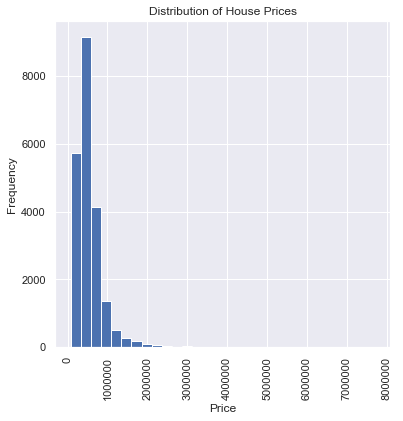

In [11]:
# Plot a histogram of house prices
pyplot.figure(figsize=(6,6))
house_df.loc[:, 'price'].plot.hist(bins=30)
pyplot.xlabel('Price')
pyplot.title('Distribution of House Prices')
pyplot.xticks(rotation = 'vertical')

(0.0, 8500000.0)

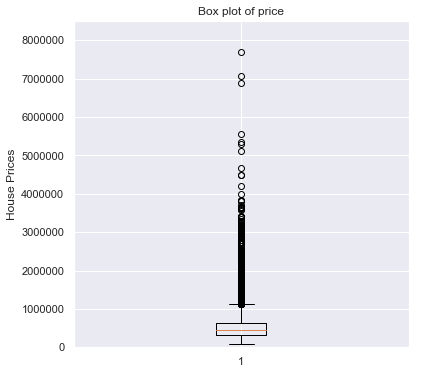

In [12]:
# Plot a box plot of house prices
fig = pyplot.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
pyplot.boxplot(house_df.loc[:, 'price'])
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('House Prices')# Set text for y axis
ax.set_ylim(0.0, 8500000.0) # Set the limits of the y axis


#### Log transformation of prices

Text(0, 0.5, 'Count')

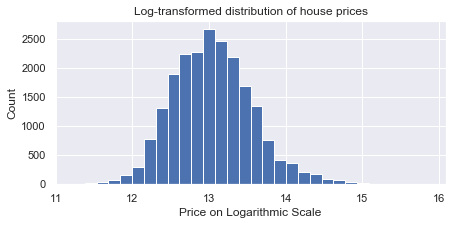

In [13]:
# Plot logs of house prices
xlog = house_df.loc[:, 'log_price']
pyplot.figure(figsize = (7,3))
pyplot.hist(xlog, bins = 30)
pyplot.title('Log-transformed distribution of house prices')
pyplot.xlabel('Price on Logarithmic Scale')
pyplot.ylabel('Count')

In [14]:
# Some summary statistics 
print('Log of median of PRICES:', house_df.log_price.median())
print('Median of PRICES, $', house_df.price.median())
print('Mean of LOGs of PRICES', xlog.mean())
print('StandDev of Prices, $', house_df.price.std())
print('StandDev of LOGs of Prices', xlog.std())

Log of median of PRICES: 13.017002861746503
Median of PRICES, $ 450000.0
Mean of LOGs of PRICES 13.047816917155423
StandDev of Prices, $ 367127.1964826997
StandDev of LOGs of Prices 0.5266845190328331


The mean of 13 is roughly equal to the median price, USD 450 000, of the original house prices. That is, numpy.log($450,000) => ~13.

In [15]:
# The range of prices +- one standard deviation from the mean
low = np.exp(xlog.mean() - xlog.std())
high = np.exp(xlog.mean() + xlog.std())
print('About 68% of prices lie within 1 st.dev. from the mean within these limits:')
print('${:.2f} - ${:.2f}'.format(low, high))

About 68% of prices lie within 1 st.dev. from the mean within these limits:
$274068.24 - $785834.46


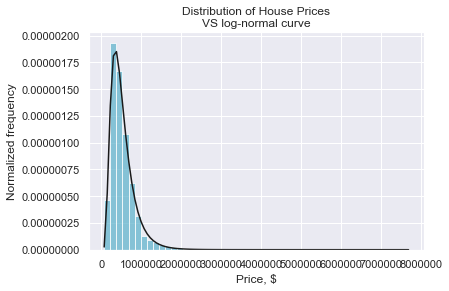

In [16]:
# From https://stackoverflow.com/questions/26406056/a-lognormal-distribution-in-python
data = house_df.loc[:, 'price']
s, loc, scaling = scipy.stats.lognorm.fit(data, floc=0)
estimated_mu = np.log(scaling)
estimated_sigma = s
pyplot.hist(data, bins=50, density=True, color='c', alpha=0.75)
xmin = data.min()
xmax = data.max()
x = np.linspace(xmin, xmax, 100)
pdf = scipy.stats.lognorm.pdf(x, s, scale=scaling)
pyplot.title('Distribution of House Prices\nVS log-normal curve')
pyplot.xlabel('Price, $')
pyplot.ylabel('Normalized frequency')
pyplot.plot(x, pdf, 'k')

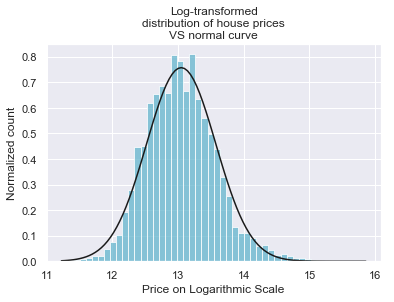

In [17]:
logprice = house_df.loc[:, 'log_price']
pyplot.hist(logprice, bins=50, density=True, color='c', alpha=0.75)
xmin = logprice.min()
xmax = logprice.max()
x = np.linspace(xmin, xmax, 100)
pdf = scipy.stats.norm.pdf(x, loc=estimated_mu, scale=estimated_sigma)
pyplot.title('Log-transformed\ndistribution of house prices\nVS normal curve')
pyplot.xlabel('Price on Logarithmic Scale')
pyplot.ylabel('Normalized count')
pyplot.plot(x, pdf, 'k')

This plot shows that the distribution of log-transformed prices is close to normal.

#### Quantile-quantile (Q-Q) plot for the log-transformed prices

Text(0.5, 1.0, 'Q-Q plot of normal and log-transformed distributions')

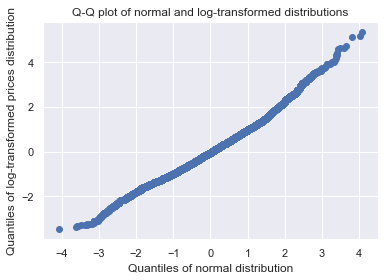

In [18]:
norm1 = nr.normal(size = len(logprice)).tolist()
norm2 = scale(logprice.tolist())
pyplot.scatter(x = sorted(norm1), y = sorted(norm2))
pyplot.xlabel('Quantiles of normal distribution')
pyplot.ylabel('Quantiles of log-transformed prices distribution')
pyplot.title('Q-Q plot of normal and log-transformed distributions')

The line of points on the Q-Q plot is close to straight, showing that both samples are realizations of normal distributions.

#### Kolmogorov-Smirnov Test for the distribution of log prices

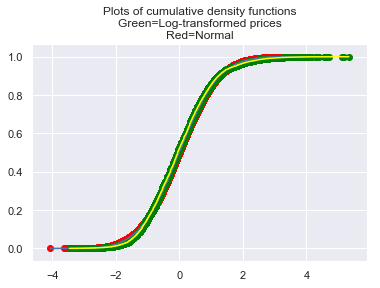

In [19]:
def plot_cums(dist1, dist2, plot_title = None):
    """Plot cdfs of the two distributions."""
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)
    
    pyplot.title(plot_title)

    # Now plot as line and scatter plot. 
    pyplot.plot(data_sorted, p)
    pyplot.scatter(data_sorted, p, color = 'red')
    
    # sort the second data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    pyplot.plot(data_sorted, p, color = 'yellow')
    pyplot.scatter(data_sorted, p, color = 'green')

plot_title = 'Plots of cumulative density functions\nGreen=Log-transformed prices\nRed=Normal'
plot_cums(norm1, norm2, plot_title = plot_title)

In [20]:
def ks_test(dat, dist = 'norm'):
    from scipy.stats import kstest 
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))
ks_test(norm2)

KS-statistic = 0.025988070503970062
P-value = 4.1903563850987136e-13


Because the p-value is very low, I fail to reject the Ho that the log-transformed prices distribution is normal.

#### Mean and standard deviation by the classical method -- log prices

In [21]:
print('Mean = {:.3f}'.format(house_df.log_price.mean()))

Mean = 13.048


In [22]:
print('Standard deviation = {:.3f}'.format(house_df.log_price.std()))

Standard deviation = 0.527


#### Mean and standard deviation by Bootstrap -- log prices

In [23]:
# Number of trials
n_replicas = 1000
# Calculate means of samples
fraction = 1  # take 100% of the data as a sample
price_bootstrap_means = pd.Series([
    house_df.sample(frac = 1, replace = True).log_price.mean() 
    for i in range(n_replicas)])
print('Mean = {:.3f}'.format(price_bootstrap_means.mean()))

Mean = 13.048


In [24]:
# Calculate standard deviations of samples
price_bootstrap_stds = pd.Series([
    house_df.sample(frac = 1, replace = True).log_price.std() 
    for i in range(n_replicas)])
print('Standard deviation = {:.3f}'.format(price_bootstrap_stds.mean()))

Standard deviation = 0.527


#### Mean and standard deviation by the Bayesian method -- log prices

The code below is an adaptation of code from L05-3-IntroductionToBayes

In [25]:
# Sample of cases from the dataset - 100% of the data
price = house_df.sample(frac = 1)
# Horizontal axis
p = np.linspace(0, 15, num = 1000)
# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = price.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

def posterior(prior, like):
    """Return an array of estimated posterior distribution.
    
       prior: an array of prior probability distribution
       like: an array of estimated likelihood distribution
    """
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity

def comp_like(p, x):
    """Return an array of estimated normal likelihood distribution.
    
       p: horizontal axis: np.linspace()
       x: a data series
    """
    variance = np.std(x)**2 # sigmasqr
    x_mean = np.asarray(x).mean()  # xbar
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return l / l.sum()

like_price = comp_like(p, price.log_price)
post_price = posterior(pp, like_price)

Mean = 13.048, Standard deviation = 0.527


### Classical Confidence Interval - for the mean of log prices

#### Classical C.I.: Approach 1 - from lesson 5

In [26]:
# Approach from notebook L05-CentralLimitTheorem
pop_mean = house_df.loc[:, 'log_price'].mean()
pop_std = house_df.sample(frac = 1, replace = True).log_price.std()
alpha = 0.95
half_width = scipy.stats.norm.ppf((1 + alpha) / 2, loc = pop_mean, scale = pop_std) - pop_mean
print('The half width is %.2f' % half_width)

ci_low = pop_mean - half_width
ci_high = pop_mean + half_width

print('The %.2f level CI is (%.2f , %.2f)' % (alpha, ci_low, ci_high))

The half width is 1.03
The 0.95 level CI is (12.02 , 14.08)


#### Classical C.I.: Approach 2 - from the Internet - same result

In [27]:
# Using scipy.stats.t.interval() produces the same result as the approach in this Lesson 05
mu = house_df.log_price.mean()
sd = house_df.log_price.std()
conf_int_t = scipy.stats.t.interval(alpha = 0.95,           # Confidence level
                              df = len(house_df.log_price) - 1,      # Degrees of freedom
                              loc = mu,               # Sample mean
                              scale = sd)             # Sample standard deviation
print('({:.3}, {:.3})'.format(conf_int_t[0], conf_int_t[1]))

(12.0, 14.1)


#### Classical C.I.: Approach 3 - from the Internet - different result but coincides with the C.I. by Bootstrap

In [28]:
# Approach from https://kite.com/python/examples/702/scipy-compute-a-confidence-interval-from-a-dataset
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95
data = house_df.loc[:, 'log_price']

n = len(data)
m = mean(data)
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print('({:.3f}, {:.3f})'.format(start, end))

(13.041, 13.055)


### Bootstap Confidence Interval - for the mean of log prices

Calculating C.I. here makes sense because I use only 10% of the data as a sample for the calculation.

In [29]:
# Using price_bootstrap_means calculated above in the section on the mean and std by Bootstrap
p = 5  # 95% confidence level
lo = np.percentile(price_bootstrap_means, p/2.)
hi = np.percentile(price_bootstrap_means, 100-p/2.)
print('({:.3}, {:.3})'.format(lo, hi))

(13.0, 13.1)


### Credible Interval by the Bayesian method - for the mean of log prices

Here, I also use only 10% of the data as a sample for the calculation.

In [30]:
# Adaptation of code from L05-3-IntroductionToBayes
def plot_ci(p, post, num_samples, lower_q, upper_q):
    """This function computes a credible interval.
    
    Uses an assumption of symmetry in the bulk of the distribution 
    to keep the calculation simple."""
    
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    pyplot.title('Posterior density with %.3f credible interval' % interval)
    pyplot.plot(p, post, color='blue')
    pyplot.xlabel('Parameter value')
    pyplot.ylabel('Density')
    pyplot.axvline(x=ci[0], color='red')
    pyplot.axvline(x=ci[1], color='red')
    print('The %.3f credible interval is %.3f to %.3f' 
          % (interval, ci[0], ci[1]))

Mean = 13.048, Standard deviation = 0.527
The 0.950 credible interval is 13.041 to 13.055


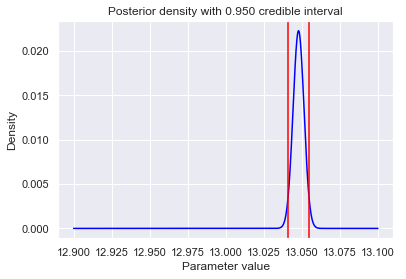

In [31]:
num_samples = 100000
lower_q, upper_q = [.025, .975]
# Horizontal axis
p = np.linspace(12.9, 13.1, num = 1000)

# Sample of cases from the dataset - 100% of the data
price = house_df.sample(frac = 1)

# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = price.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

L = comp_like(p, price.log_price)
post = posterior(pp, L)
plot_ci(p, post, num_samples, lower_q, upper_q)

### Box plots and scatter plots for house size-related attributes <a id='sizes'></a>

Surprisingly, the number of bedrooms or bathrooms plotted below does not seem to have a strong positive linear relationship with the price. I hoped that the larger would mean more expensive. [Go to top](#top)

(0.0, 8500000.0)

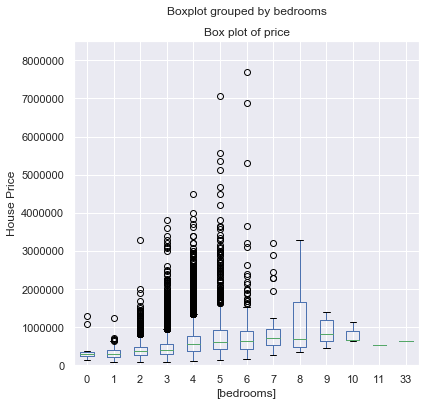

In [32]:
# Plot the box plots of house prices grouped by bedrooms
fig = pyplot.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
house_df.loc[:, ['price', 'bedrooms']].boxplot(by = 'bedrooms', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('House Price')# Set text for y axis
ax.set_ylim(0.0, 8500000.0) # Set the limits of the y axis
# ax.set_ylim(10.0, 25.0)

In [33]:
#Tukey’s Honest Significant Differences (HSD) for the log price stratified by the number of bedrooms
# What groups by the number of bedrooms are there?
unique_door_nums = house_df.loc[:, 'bedrooms'].unique()
unique_door_nums

array([ 3,  2,  4,  5,  1,  6,  7,  0,  8,  9, 11, 10, 33])

In [34]:
# Get a list of category names and prices if the # of cases in each group exceeds 5
all_categories = []
category_names = []
for cat in unique_door_nums:
    price = get_log_prices(house_df, 'bedrooms', cat)
    if len(price) > 5:
        category_names.append(cat)
        all_categories.append(price)

In [35]:
print('# of cases in each category')
num_cases = [len(i) for i in all_categories]
print(num_cases)
print('categories: # of bedrooms')
print(category_names)

# of cases in each category
[9824, 2760, 6882, 1601, 199, 272, 38, 13, 13, 6]
categories: # of bedrooms
[3, 2, 4, 5, 1, 6, 7, 0, 8, 9]


In [36]:
# Anova analysis
f_statistic, p_value = scipy.stats.f_oneway(*all_categories)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 363.05211823201955
P-value = 0.0


Because the p-value is very small, I must reject Ho that there is no difference among the mean log prices by the number of bedrooms.

In [37]:
# Tukey’s Honest Significant Differences (HSD) 
df = pd.DataFrame({'vals': list(itertools.chain.from_iterable(all_categories)),
                   'group_num': [category_names[0]] * num_cases[0] 
                              + [category_names[1]] * num_cases[1]
                              + [category_names[2]] * num_cases[2]
                              + [category_names[3]] * num_cases[3]
                              + [category_names[4]] * num_cases[4]
                              + [category_names[5]] * num_cases[5]
                              + [category_names[6]] * num_cases[6]
                              + [category_names[7]] * num_cases[7]
                              + [category_names[8]] * num_cases[8]
                              + [category_names[9]] * num_cases[9]
                  })
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  0      1    -0.1199  -0.5647 0.3248 False 
  0      2     0.1159   -0.316 0.5478 False 
  0      3     0.2533  -0.1779 0.6844 False 
  0      4     0.5391   0.1078 0.9703  True 
  0      5     0.7058   0.2732 1.1384  True 
  0      6     0.7207   0.2797 1.1618  True 
  0      7     0.8639   0.3647 1.363   True 
  0      8     0.9706   0.3613  1.58   True 
  0      9     0.9402   0.1735 1.7069  True 
  1      2     0.2358   0.1218 0.3499  True 
  1      3     0.3732   0.262  0.4844  True 
  1      4     0.659    0.5473 0.7707  True 
  1      5     0.8258   0.709  0.9425  True 
  1      6     0.8407   0.6958 0.9856  True 
  1      7     0.9838   0.7088 1.2588  True 
  1      8     1.0906   0.6459 1.5353  True 
  1      9     1.0602   0.4165 1.7039  True 
  2      3     0.1374   0.1039 0.1708  True 
  2      4     0.4232   0.3882 0.4582  True 
  2 

The above table shows which groups exactly have significantly different means.

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]),
 <a list of 11 Text xticklabel objects>)

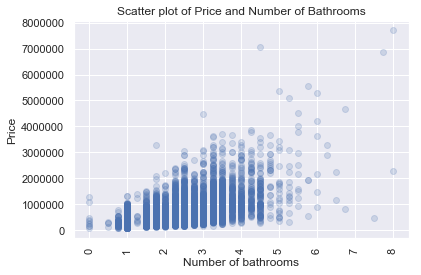

In [38]:
# Plot a scatter plot of price vs bathrooms
pyplot.scatter(house_df.loc[:, 'bathrooms'],
                house_df.loc[:, 'price'], alpha = 0.2)
pyplot.xlabel('Number of bathrooms')
pyplot.ylabel('Price')
pyplot.title('Scatter plot of Price and Number of Bathrooms')
pyplot.xticks(rotation = 'vertical')

The same is true for the living area.

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000.]),
 <a list of 8 Text xticklabel objects>)

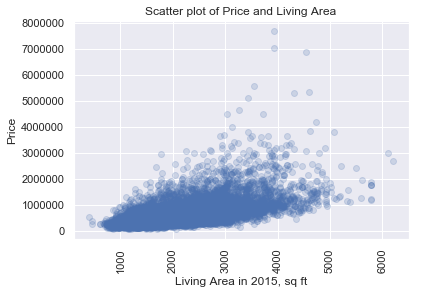

In [39]:
# Plot a scatter plot of price vs sqft_living
pyplot.scatter(house_df.loc[:, 'sqft_living15'],
                house_df.loc[:, 'price'], alpha = 0.2)
pyplot.xlabel('Living Area in 2015, sq ft')
pyplot.ylabel('Price')
pyplot.title('Scatter plot of Price and Living Area')
pyplot.xticks(rotation = 'vertical')

Text(0.5, 1.0, 'House Price vs. Living Area \n with waterfront view by color')

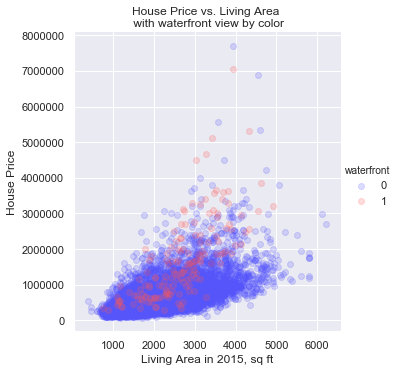

In [40]:
# Plot prices vs living area15 and color up waterfront
sns.lmplot(x = 'sqft_living15', y = 'price', 
           data = house_df, 
           hue = "waterfront", 
           palette="seismic", 
           scatter_kws={'alpha': 0.2},
           fit_reg = False)
pyplot.xlabel('Living Area in 2015, sq ft')
pyplot.ylabel('House Price')
pyplot.title('House Price vs. Living Area \n with waterfront view by color')

The scatter plot of price vs sqft_lot15. I am not sure this relationship will be useful.

(array([-200000.,       0.,  200000.,  400000.,  600000.,  800000.,
        1000000.]), <a list of 7 Text xticklabel objects>)

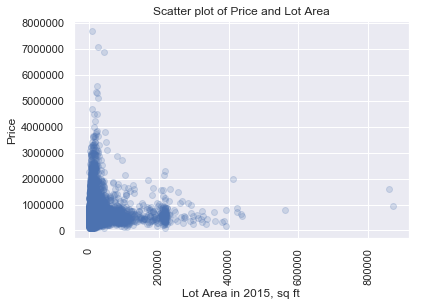

In [41]:
# Scatter plot of price vs sqft_lot15
pyplot.scatter(house_df.loc[:, 'sqft_lot15'],
                house_df.loc[:, 'price'], alpha = 0.2)
pyplot.xlabel('Lot Area in 2015, sq ft')
pyplot.ylabel('Price')
pyplot.title('Scatter plot of Price and Lot Area')
pyplot.xticks(rotation = 'vertical')

Knowing the number of floors, just like the above quantitative characterisitics, will not help either.

(0.0, 8500000.0)

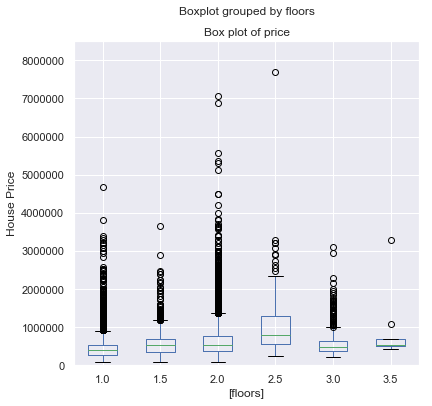

In [42]:
# Plot the box plots of house prices grouped by floors
fig = pyplot.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
house_df.loc[:, ['price', 'floors']].boxplot(by = 'floors', ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('House Price')# Set text for y axis
ax.set_ylim(0.0, 8500000.0) # Set the limits of the y axis

The correlation coefficient between sqft_living15 and price was 0.59. The scatter plot below does look promising. I added the color code for those houses that were renovated but that does not make any difference.

Text(0.5, 1.0, 'House Price vs. Living Area \n with renovation status by color')

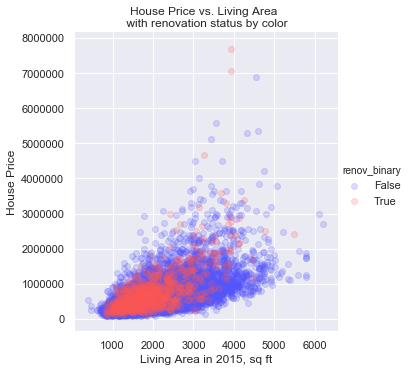

In [43]:
# Do renovated houses attract higher prices in general? It does not seem so.
# Create a new binary attribute with True's if the house was ever renovated
house_df['renov_binary'] = house_df.loc[:, 'yr_renovated'] != 0

# Plot prices vs living area15 and color up renovation status
sns.lmplot(x = 'sqft_living15', y = 'price', 
           data = house_df, 
           hue = "renov_binary", 
           palette="seismic", 
           scatter_kws={'alpha': 0.2},
           fit_reg = False)
pyplot.xlabel('Living Area in 2015, sq ft')
pyplot.ylabel('House Price')
pyplot.title('House Price vs. Living Area \n with renovation status by color')

The fact that the house has been renovated does not seem to be a telling factor on its own in predicting the house price.

Text(0.5, 1.0, 'House Price vs. Area (other than basement)\n with waterfront view by color')

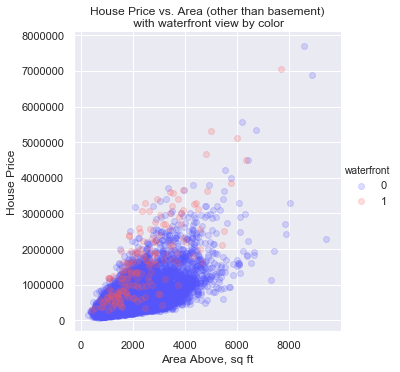

In [44]:
# Plot prices vs area above ground (corr. was 0.6) and color up waterfront
sns.lmplot(x = 'sqft_above', y = 'price', 
           data = house_df, 
           hue = "waterfront", 
           palette="seismic", 
           scatter_kws={'alpha': 0.2},
           fit_reg = False)
pyplot.xlabel('Area Above, sq ft')
pyplot.ylabel('House Price')
pyplot.title('House Price vs. Area (other than basement)\n with waterfront view by color')

Text(0.5, 1.0, 'House Price vs. Area (basement)\n with waterfront view by color')

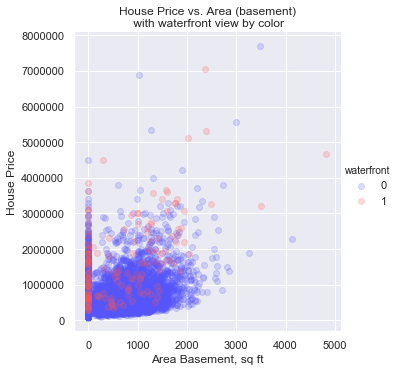

In [45]:
# Plot prices vs area below ground and color up waterfront
sns.lmplot(x = 'sqft_basement', y = 'price', 
           data = house_df, 
           hue = "waterfront", 
           palette="seismic", 
           scatter_kws={'alpha': 0.2},
           fit_reg = False)
pyplot.xlabel('Area Basement, sq ft')
pyplot.ylabel('House Price')
pyplot.title('House Price vs. Area (basement)\n with waterfront view by color')

### Prices stratified by waterfront view <a id='waterfront'></a>

The waterfront view should be more helpful. These two groups of houses show some diffirentiation. The median price of the waterfront-view houses is higher than that of the other group. [Go to top](#top)

(0.0, 8500000.0)

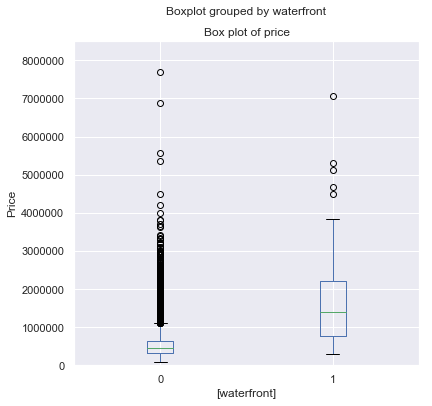

In [46]:
# Box plot of price grouped by waterfront
fig = pyplot.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
house_df.loc[:,['price', 'waterfront']].boxplot(by = ['waterfront'], ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Price')# Set text for y axis
ax.set_ylim(0.0, 8500000.0) # Set the limits of the y axis

In [47]:
# Get log prices stratified by waterfront view
no_waterfront = get_log_prices(house_df, 'waterfront', 0)
waterfront = get_log_prices(house_df, 'waterfront', 1)

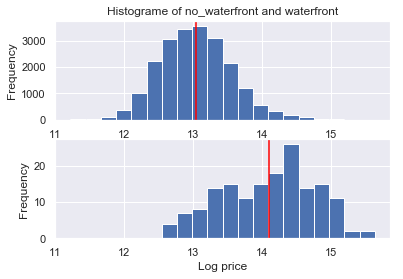

In [48]:
def hist_plot(vec, bins):
    import matplotlib.pyplot as pyplot
    from statistics import mean
    pyplot.hist(vec, bins = bins)
    pyplot.axvline(mean(vec), color = 'red')
    pyplot.ylabel('Frequency')
    pyplot.xlabel('Log price')
    
def plot_pop(a, b, cols=['no_waterfront', 'waterfront'], nbins = 20):
    import matplotlib.pyplot as pyplot
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    pyplot.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    pyplot.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    pyplot.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

plot_pop(no_waterfront, waterfront, cols = ['no_waterfront', 'waterfront'])  

T-test for the difference between the means - house log prices by waterfront view

In [49]:
def t_test(a, b, alpha, alternative='two-sided'):
    """Return results of Welche's test for paired data."""
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

test = t_test(no_waterfront, waterfront, 0.05)
test

DegFreedom     1.633993e+02
Difference    -1.062816e+00
Statistic     -2.606569e+01
PValue        1.695901e-147
Low95CI       -1.169249e+00
High95CI      -9.563836e-01
dtype: float64

Plotting histograms of prices stratified by waterfront view, with the confidence interval and means shown.

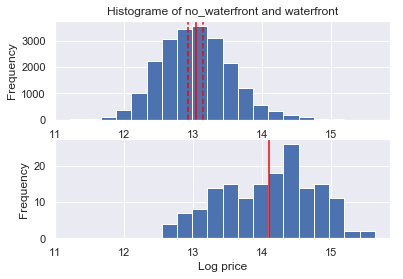

In [50]:
def hist_mean_ci(vec, t_test, bins):
    import matplotlib.pyplot as pyplot
    from statistics import mean
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    pyplot.hist(vec, bins = bins)
    pyplot.axvline(mean(vec), color = 'red')
    pyplot.axvline(upper, color = 'red', linestyle='--')
    pyplot.axvline(lower, color = 'red', linestyle='--')
    pyplot.ylabel('Frequency')
    pyplot.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_D', 'pop_G'], nbins = 20):
    import matplotlib.pyplot as pyplot
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    pyplot.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    pyplot.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    pyplot.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

plot_t(no_waterfront, waterfront, test, cols = ['no_waterfront', 'waterfront'])    

The p-value is very small. The confidence intervals do not overlap and do not include the zero difference. I, therefore, **reject the null hyposesis** of no differnce between the means of log prices stratified by waterfront view. The difference in means is **significant**.

**Anova analysis**

In [51]:
f_statistic, p_value = scipy.stats.f_oneway(no_waterfront, waterfront)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 679.4200864107797
P-value = 1.6959013227156312e-147


Because the p-value is very small, I must **reject Ho** that there is no difference among the mean prices by waterfront view.

**Tukey’s Honest Significant Differences (HSD)**

In [52]:

df = pd.DataFrame({'vals': list(itertools.chain.from_iterable([no_waterfront, waterfront])),
                   'group_num': ['no_waterfront_view'] * len(no_waterfront) 
                              + ['waterfront_view'] * len(waterfront) 
                  })
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
      group1            group2     meandiff lower  upper  reject
----------------------------------------------------------------
no_waterfront_view waterfront_view  1.0628  0.9829 1.1427  True 
----------------------------------------------------------------


The above table further confirms that the two groups I am comparing have significantly different means, with a recommendation to **reject Ho** and infere that the **difference is significant**.

**Bootstrap method - Difference in means between two categories**

In [53]:
def bootstrap_mean_diff_prices(df, variable, categories, n_replicas, fraction):
    """Return a pandas.series of differences in means for log prices."""
    mean_diff = []
    for i in range(n_replicas):
        sample = df.sample(frac = fraction, replace = True)
        categ_one_mean = get_log_prices(sample, variable, categories[0]).mean()
        categ_two_mean = get_log_prices(sample, variable, categories[1]).mean()
        mean_diff.append(categ_two_mean - categ_one_mean)
    return pd.Series(mean_diff)

In [54]:
def plot_hist(x, p=5):
    """Plot the distribution and mark the mean."""
    pyplot.hist(x, alpha=.5)
    pyplot.axvline(x.mean())
    # 95% confidence interval    
    pyplot.axvline(np.percentile(x, p/2.), color='red', linewidth=3)
    pyplot.axvline(np.percentile(x, 100-p/2.), color='red', linewidth=3)

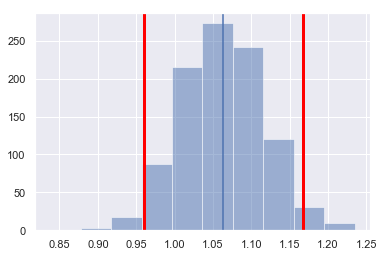

In [55]:
diff_prices_water = bootstrap_mean_diff_prices(house_df,      ## dataframe
                                               'waterfront',  ## variable
                                               [0, 1],        ## categories
                                               n_replicas,    ## number of trials
                                               1            ## sample size, 1 = 100%
                                              )

plot_hist(diff_prices_water)

**Reject Ho**: For the difference of means of log-prices by the waterfront view, the C.I. of the difference of means does not include zero. I infer that the means of the two populations are **significantly different**.

**Bayesian model - Difference in log prices by waterfront view**

First, calculate the Credible Interval for the mean log price estimate for houses with no waterfront view.

Mean = 13.040, Standard deviation = 0.517
The 0.950 credible interval is 13.033 to 13.047


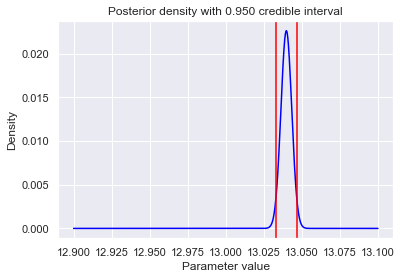

In [56]:
num_samples = 100000
lower_q, upper_q = [.025, .975]
# Horizontal axis
p = np.linspace(12.9, 13.1, num = 1000)

# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = house_df.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

L = comp_like(p, get_log_prices(house_df, 'waterfront', 0))
post = posterior(pp, L)
plot_ci(p, post, num_samples, lower_q, upper_q)

Now, calculate the Credible Interval for the mean log price estimate for houses with the waterfront view.

Mean = 14.103, Standard deviation = 0.685
The 0.950 credible interval is 13.997 to 14.207


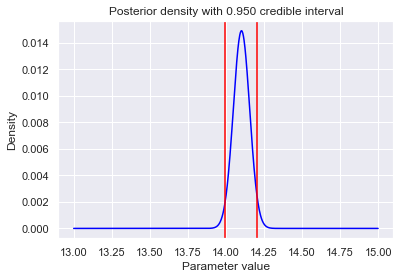

In [57]:
# Horizontal axis
p = np.linspace(13, 15, num = 1000)

# Prior normal probability distribution
pp = scipy.stats.norm.pdf(p, loc = house_df.log_price.mean(), scale = 5)
pp = pp / pp.sum() # normalize

L = comp_like(p, get_log_prices(house_df, 'waterfront', 1))
post = posterior(pp, L)
plot_ci(p, post, num_samples, lower_q, upper_q)

Because the credible intervals **do not overlap**, I reject the Ho that there is no difference in the mean prices for houses with and without waterfront view.

### Grade <a id='grade'></a>

The Grade is probably the single most useful attribute for predicting the house price, as the box plot below suggests. As the grade increases the price increases too. Although, unfortunately, there are outliers in almost every grade. [Go to top](#top)

(0.0, 8500000.0)

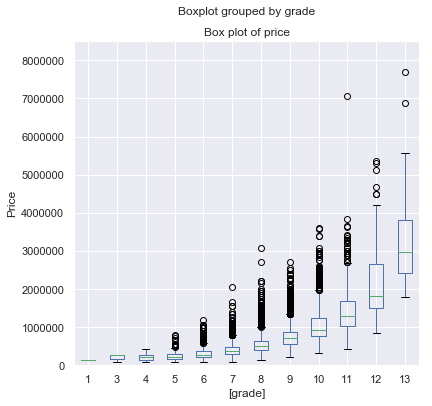

In [58]:
# Box plot of price grouped by grade
fig = pyplot.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
house_df.loc[:,['price', 'grade']].boxplot(by = ['grade'], ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Price')# Set text for y axis
ax.set_ylim(0.0, 8500000.0) # Set the limits of the y axis

Text(0.5, 1.0, 'House Price vs. Grade\n with renovation status by color')

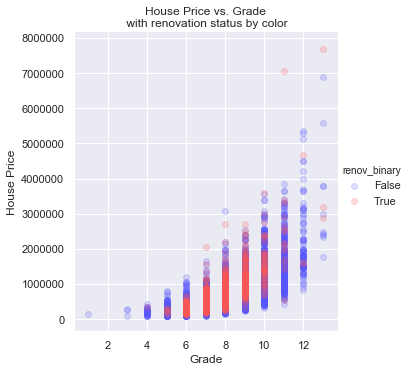

In [59]:
# Plot prices vs grade and color up renovation status
sns.lmplot(x = 'grade', y = 'price', 
           data = house_df, 
           hue = 'renov_binary', 
           palette="seismic", 
           scatter_kws={'alpha': 0.2},
           fit_reg = False)
pyplot.xlabel('Grade')
pyplot.ylabel('House Price')
pyplot.title('House Price vs. Grade\n with renovation status by color')

The above plot shows that there are very few cases in the first 3 or 4 grades and in the last grade. Also, as before, the color-coded renovation status is merely a distraction.

### Zipcodes <a id='zipcodes'></a>

Some zipcodes are associated with a narrower lower price band. [Go to top](#top)

(array([97975., 98000., 98025., 98050., 98075., 98100., 98125., 98150.,
        98175., 98200., 98225.]), <a list of 11 Text xticklabel objects>)

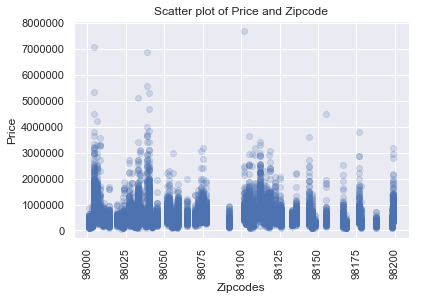

In [60]:
# Scatter plot of zipcodes vs price
pyplot.scatter(house_df.loc[:, 'zipcode'],
                house_df.loc[:, 'price'], alpha = 0.2)
pyplot.xlabel('Zipcodes')
pyplot.ylabel('Price')
pyplot.title('Scatter plot of Price and Zipcode')
pyplot.xticks(rotation = 'vertical')

### Viewed Status

The fact that the house has been viewed or not is very marginally informative, with the maximum number of views reflecting a range of prices whose median is slightly higher.

(0.0, 8500000.0)

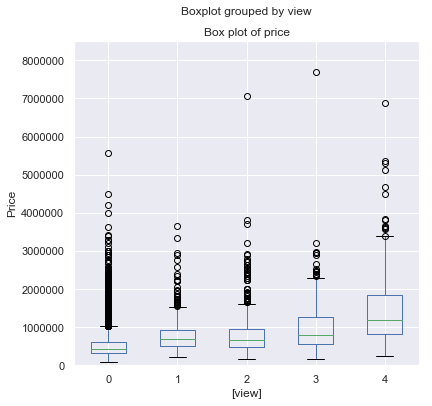

In [61]:
# Box plot of price grouped by viewed
fig = pyplot.figure(figsize=(6, 6)) # Define plot area
ax = fig.gca() # Define axis 
house_df.loc[:,['price', 'view']].boxplot(by = ['view'], ax = ax)
ax.set_title('Box plot of price') # Give the plot a main title
ax.set_ylabel('Price')# Set text for y axis
ax.set_ylim(0.0, 8500000.0) # Set the limits of the y axis

The chart below probably shows that people might enjoy viewing houses facing the waterfront. [Go to top](#top)

Text(0.5, 1.0, 'House Price vs. Viewed Status\n with waterfront view by color')

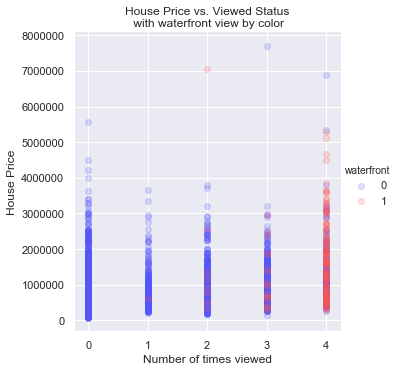

In [62]:
# Plot prices vs the number of times views and color up waterfront
sns.lmplot(x = 'view', y = 'price', 
           data = house_df, 
           hue = "waterfront", 
           palette="seismic", 
           scatter_kws={'alpha': 0.2},
           fit_reg = False)
pyplot.xlabel('Number of times viewed')
pyplot.ylabel('House Price')
pyplot.title('House Price vs. Viewed Status\n with waterfront view by color')

[Go to top](#top)

## Data preparation for Linear Regression analysis <a id='data_preparation'></a>

There is a relatively small number of houses for which the <b><i>'yr_renovated'</i></b> feature is not zero. 

I will use the <b><i>'renov_binary'</i></b> feature, created ealier, instead of <b><i>'yr_renovated'</i></b>. This newly created feature will show if the house was renovated or not. I will convert it from True-False to 0-1.

In [63]:
house_df.loc[:, 'renov_binary'] = house_df.loc[:, 'renov_binary'].astype(int)
house_df['renov_binary'].dtypes

dtype('int64')

In [64]:
# Check what I have in the 'renov_binary' feature after replacement with 0s and 1s
for i in range(2):
    L = len(house_df[house_df.loc[:, 'renov_binary'] == i])
    print('Number of cases where renov_binary == {}: {}'.format(i, L))

Number of cases where renov_binary == 0: 20699
Number of cases where renov_binary == 1: 914


The <b><i>zipcode</i></b> feature is in fact categorical but its type is 'int'. I will change that to string, so that it will be one-hot encoded later.

In [65]:
house_df.loc[:, 'zipcode'] = house_df.loc[:, 'zipcode'].astype(str)
print('Number of unique zipcodes:', len(house_df['zipcode'].unique()))
print('Zipcode data type:', house_df.loc[:, 'zipcode'].dtypes)

Number of unique zipcodes: 70
Zipcode data type: object


In [66]:
# Define the target and features
target_label = 'log_price'
non_features = ['price', 'id', 'date', 'yr_renovated', 'lat', 'long']
feature_labels = [x for x in house_df.columns if x not in [target_label] + non_features]

In [67]:
# Filter out non-features and non-targets
house_df = house_df.drop(non_features, axis = 1)
print('DataFrame original shape: {}'.format(house_df.shape))

DataFrame original shape: (21613, 17)


In [68]:
# One-hot encode inputs
house_expanded = pd.get_dummies(house_df, drop_first = True)
print('DataFrame one-hot-expanded shape: {}'.format(house_expanded.shape))

DataFrame one-hot-expanded shape: (21613, 85)


In [69]:
def apply_znorm(a_dataset, vars_to_znorm):
    """Return the dataset with z-normalized variables."""
    dset = deepcopy(a_dataset)
    for cat in vars_to_znorm:
        column = dset[[cat]].astype(float)
        dset[cat] = preprocessing.StandardScaler().fit_transform(column)

    return dset

house_expanded_scaled = apply_znorm(house_expanded, house_expanded.columns)

In [70]:
house_expanded_scaled.shape

(21613, 85)

## Multiple Ordinary Least Squares Regression <a id='ols_regression'></a>

In [71]:
# Define the formula for the linear regression
formula_start = target_label + ' ~ '
formula_terms = [term for term in house_expanded_scaled.columns if term != target_label]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

In [72]:
print(formula_final)

log_price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + waterfront + view + condition + grade + sqft_above + sqft_basement + yr_built + sqft_living15 + sqft_lot15 + renov_binary + zipcode_98002 + zipcode_98003 + zipcode_98004 + zipcode_98005 + zipcode_98006 + zipcode_98007 + zipcode_98008 + zipcode_98010 + zipcode_98011 + zipcode_98014 + zipcode_98019 + zipcode_98022 + zipcode_98023 + zipcode_98024 + zipcode_98027 + zipcode_98028 + zipcode_98029 + zipcode_98030 + zipcode_98031 + zipcode_98032 + zipcode_98033 + zipcode_98034 + zipcode_98038 + zipcode_98039 + zipcode_98040 + zipcode_98042 + zipcode_98045 + zipcode_98052 + zipcode_98053 + zipcode_98055 + zipcode_98056 + zipcode_98058 + zipcode_98059 + zipcode_98065 + zipcode_98070 + zipcode_98072 + zipcode_98074 + zipcode_98075 + zipcode_98077 + zipcode_98092 + zipcode_98102 + zipcode_98103 + zipcode_98105 + zipcode_98106 + zipcode_98107 + zipcode_98108 + zipcode_98109 + zipcode_98112 + zipcode_98115 + zipcode_98116 + zipcode

In [73]:
# Get y-target and x-predictor data
y_house = house_expanded_scaled.loc[:, 'log_price']
x_house = house_expanded_scaled.drop('log_price', axis = 1)

# Shapes and types of the data
for i in [y_house, x_house]:
     print(i.shape, type(i))

(21613,) <class 'pandas.core.series.Series'>
(21613, 84) <class 'pandas.core.frame.DataFrame'>


In [74]:
#Split the dataset 80/20 into train X, test XX, label train Y, label test YY.
X_train, XX_test, Y_train, YY_test = train_test_split(x_house,
                                                      y_house,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0)

# Shapes and types of the data split into train/test
for i in [X_train, XX_test, Y_train, YY_test]:
     print(i.shape, type(i))

(17290, 84) <class 'pandas.core.frame.DataFrame'>
(4323, 84) <class 'pandas.core.frame.DataFrame'>
(17290,) <class 'pandas.core.series.Series'>
(4323,) <class 'pandas.core.series.Series'>


In [75]:
# Combine the Y-train series and X-train dataframe
X_train = pd.concat([X_train, Y_train], axis = 1)
X_train.shape

(17290, 85)

In [76]:
# Train an OLS regression model on the X-train data (which includes Y-train data)
ols_model = sm.ols(formula = formula_final, data = X_train).fit()

In [77]:
# Compute predictions for the train set first. Compare to test results (overfit check).
y_pred_train = ols_model.predict(X_train.loc[:, [col for col in X_train.columns if col != 'log_price']])

# Evaluate the model results:
# The mean squared error
print("Root mean squared error: %.5f"
      % np.sqrt(mean_squared_error(Y_train, y_pred_train))
     )
# Explained variance score: 1 is perfect prediction
print('Variance score (r-squared): %.5f' % r2_score(Y_train, y_pred_train)
     )

Root mean squared error: 0.35196
Variance score (r-squared): 0.87718


In [78]:
# Make predictions using the testing set
y_pred = ols_model.predict(XX_test)

# Evaluate the model results:
# The mean squared error
print("Root mean squared error: %.5f"
      % np.sqrt(mean_squared_error(YY_test, y_pred))
     )
# Explained variance score: 1 is perfect prediction
print('Variance score (r-squared): %.5f' % r2_score(YY_test, y_pred)
     )

Root mean squared error: 0.34702
Variance score (r-squared): 0.87516


The results on the train and test sets are almost identical - the model does not look overfitted. 

In [79]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     1481.
Date:                Thu, 14 Mar 2019   Prob (F-statistic):               0.00
Time:                        13:44:29   Log-Likelihood:                -6478.5
No. Observations:               17290   AIC:                         1.313e+04
Df Residuals:                   17206   BIC:                         1.378e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0013      0.003     -0.475      0.635      -0.007       0.004
bedrooms          0.0102      0.003      2.964      0.003       0.003       0.017
bathrooms         0.0583      0.005     11.813      0.000       0.049       0.068
sqft_living       0.1606      0.003     50.781      0.000       0.154       0.167
sqft_lot          0.0522      0.004     13.245      0.000       0.044       0.060
floors           -0.0314      0.004     -7.523      0.000      -0.040      -0.023
waterfront        0.0768      0.003     26.368      0.000       0.071       0.082
view              0.0822      0.003     24.882      0.000       0.076       0.089
condition         0.0731      0.003     23.721      0.000       0.067       0.079
grade             0.2069      0.005     39.604      0.000       0.197       0.217
sqft_above        0.1640      0.003     47.724      0.000       0.157       0.171
sqft_basement     0.0264      0.003      8.401      0.000       0.020       0.033
yr_built         -0.0216      0.005     -4.624      0.000      -0.031      -0.012
sqft_living15     0.1129      0.005     23.364      0.000       0.103       0.122
sqft_lot15       -0.0037      0.004     -0.908      0.364      -0.012       0.004
renov_binary      0.0292      0.003     10.187      0.000       0.024       0.035
zipcode_98002    -0.0060      0.003     -1.774      0.076      -0.013       0.001
zipcode_98003     0.0047      0.004      1.320      0.187      -0.002       0.012
zipcode_98004     0.2501      0.004     68.715      0.000       0.243       0.257
zipcode_98005     0.1210      0.003     37.258      0.000       0.115       0.127
zipcode_98006     0.1735      0.004     41.967      0.000       0.165       0.182
zipcode_98007     0.0976      0.003     30.782      0.000       0.091       0.104
zipcode_98008     0.1389      0.004     39.295      0.000       0.132       0.146
zipcode_98010     0.0334      0.003     11.178      0.000       0.028       0.039
zipcode_98011     0.0797      0.003     23.968      0.000       0.073       0.086
zipcode_98014     0.0476      0.003     15.079      0.000       0.041       0.054
zipcode_98019     0.0586      0.003     17.736      0.000       0.052       0.065
zipcode_98022     0.0082      0.003      2.417      0.016       0.002       0.015
zipcode_98023    -0.0077      0.004     -1.877      0.061      -0.016       0.000
zipcode_98024     0.0477      0.003     16.442      0.000       0.042       0.053
zipcode_98027     0.1300      0.004     33.479      0.000       0.122       0.138
zipcode_98028     0.0916      0.004     25.765      0.000       0.085       0.099
zipcode_98029     0.1369      0.004     37.608      0.000       0.130       0.144
zipcode_98030     0.0125      0.004      3.560      0.000       0.006       0.019
zipcode_98031     0.0160      0.004      4.500   

The model includes several terms with p-values above a=0.05 which could probably be removed to simplify the model.

In [81]:
# Plot histograms of actual and predicted z-normalized log prices
def plot_actual_vs_pred(actual, predicted, title, bins=None):
    """Plot histograms of actual and predicted values."""
    if bins == None:
        bins = np.linspace(-5, 5, 100)
    pyplot.hist(actual, bins, alpha=0.5, label='Actual')
    pyplot.hist(predicted, bins, alpha=0.5, label='Predicted')
    pyplot.legend(loc='upper right')
    pyplot.title('Histograms of actual and predicted ' + title)
    pyplot.xlabel(title)
    pyplot.ylabel('Frequency')
    pyplot.show()

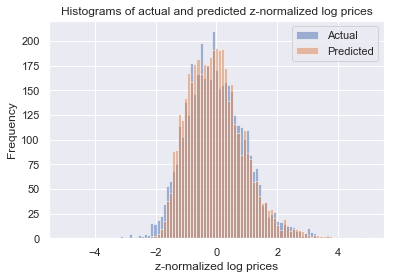

In [82]:
plot_actual_vs_pred(YY_test, y_pred,'z-normalized log prices')

The the <b>r-squared score</b> of <b>0.87516</b> and <b>root mean squared error</b> of <b>0.34702</b> can be used to compare performance of the ordinary least squares regression to other regression models. The r-squared is rather close to 1 which means that this model is not bad. The model results on the train and test sets are almost identical - the model does not look overfitted. The above histogram shows that predicted and actual values more or less closely overlap each other.

## Naive Bayes analysis <a id='naive_bayes'></a>

[Back to top](#top)

Because all the data in the set is numerical I will bin all continuous variables. First, I will create a model for the entire dataset. Then, I will split the dataset into train and test sets to check that the model has equal performance in either case. 

In [83]:
# Set the number of bins
num_bins = 10

In [84]:
def apply_binning(a_dataset, vars_to_bin, num_bins):
    """Return the dataset with binned variables."""
    dataset_copy = deepcopy(a_dataset)

    for cat in vars_to_bin:
        dataset_copy.loc[:, cat] = pd.cut(dataset_copy.loc[:, cat],
                                          bins=num_bins,
                                          labels=range(num_bins)
                                          )
    return dataset_copy

In [85]:
# Variables to be binned into categories
binning_vars = ['sqft_living', 'sqft_lot',
                'sqft_above', 'sqft_basement',
                'sqft_living15', 'sqft_lot15',
                'log_price']

In [86]:
house_df_binned = apply_binning(house_df, binning_vars, num_bins)

In [87]:
house_df_binned.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,log_price,renov_binary
0,3,1.00,0,0,1.0,0,0,3,7,0,0,1955,98178,1,0,2,0
1,3,2.25,1,0,2.0,0,0,3,7,2,0,1951,98125,2,0,4,1
2,2,1.00,0,0,1.0,0,0,3,6,0,0,1933,98028,3,0,1,0
3,4,3.00,1,0,1.0,0,0,5,7,0,1,1965,98136,1,0,4,0
4,3,2.00,1,0,1.0,0,0,3,8,1,0,1987,98074,2,0,4,0


In [88]:
# Set the target variable
price_label_col = 'log_price'
price_labels = house_df_binned[price_label_col]

In [89]:
# Create feature vectors 
features = []

for c in house_df_binned.columns:
    if c != price_label_col:
        if str(house_df_binned[c].dtype) == 'category':
            features.append(house_df_binned[c].cat.codes)
        else:
            features.append(house_df_binned[c])
        
house_feature_vecs = np.array(features).T

In [90]:
# Create the Naive Bayes model
NB_model = sklearn.naive_bayes.MultinomialNB(alpha = 1)
NB_model.fit(house_feature_vecs, price_labels)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [91]:
def confusion_matrix(labels, predicted_labels, label_classes):
    """Return a dataframe with a confusion matrix."""
    return pd.DataFrame(
        sklearn.metrics.confusion_matrix(labels, predicted_labels),
        index=[label_classes], 
        columns=label_classes)    

In [92]:
# Predict and evaluate
predicted_price = NB_model.predict(house_feature_vecs)

accuracy = sklearn.metrics.accuracy_score(price_labels, predicted_price)
precision = sklearn.metrics.precision_score(price_labels, predicted_price, average='weighted')
recall = sklearn.metrics.recall_score(price_labels, predicted_price, average='weighted')
print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy, precision, recall))

Accuracy = 0.422, Precision = 0.412, Recall = 0.422


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [93]:
# Get a confusion matrix for the predicted and actual values
conf_matrix = confusion_matrix(price_labels,
                               predicted_price,
                               sorted(house_df_binned[price_label_col].unique()))

In [94]:
print('Confusion matrix:')
conf_matrix

Confusion matrix:


,0,1,2,3,4,5,6,7,8,9
0,0,0,62,1,0,0,0,0,0,0
1,0,0,420,110,3,0,0,0,0,0
2,1,0,1651,1992,321,11,1,0,0,0
3,0,0,1748,3355,1895,164,21,0,0,0
4,0,0,532,2215,2832,656,108,2,0,0
5,0,0,23,262,1006,993,240,12,4,1
6,0,0,0,6,152,299,238,30,6,2
7,0,0,0,0,1,61,86,37,6,2
8,0,0,0,0,0,5,6,18,8,1
9,0,0,0,0,0,0,0,0,4,3


In [95]:
def print_heatmap(conf_matrix, title, labels):
    """Print a confusion matrix as a heat map, with labels from a list."""
    fig, ax = pyplot.subplots(figsize=(10,10)) 
    sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=labels, yticklabels=labels, ax=ax)
    pyplot.xlabel('Actual labels')
    pyplot.ylabel('Predicted labels')
    pyplot.title(title)
    pyplot.show()

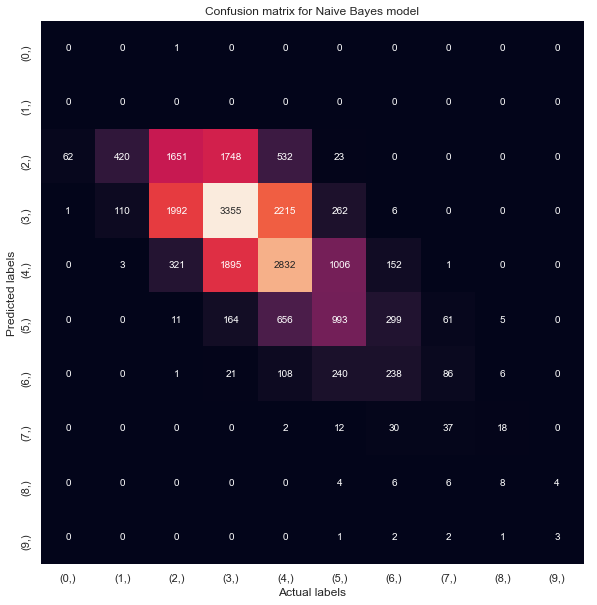

In [96]:
# A better presented confusion matrix from seaborn
print_heatmap(conf_matrix.T,
              'Confusion matrix for Naive Bayes model',
              conf_matrix.index)

The confusion matrix shows the number of correctly classified labels along the main diagonal. All values not on the main diagonal show the number of misclassified cases.

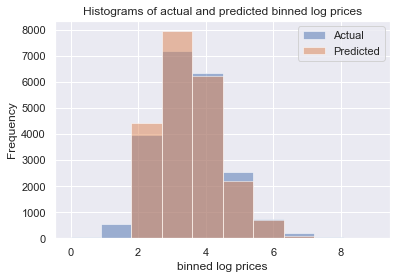

In [97]:
# Plot histograms of actual and predicted binned log prices
plot_actual_vs_pred(price_labels, 
                    predicted_price, 
                    'binned log prices', 
                    bins=num_bins)

The above plot does not look very bad. But if I increase the number of bins, the number of misclassified cases in each bin increases dramatically.

#### The cell below includes code for splitting the dataset into train and test data.

In [98]:
# Get x and y values from the binned dataframe
y_house_nb = house_df_binned.loc[:, 'log_price']
x_house_nb = house_df_binned.drop('log_price', axis = 1)
     
#Split the dataset 80/20 into train X, test XX, label train Y, label test YY.
X_train_nb, XX_test_nb, Y_train_nb, YY_test_nb = train_test_split(x_house_nb,
                                                      y_house_nb,
                                                      train_size=0.8,
                                                      test_size=0.2,
                                                      random_state=0)

# Combine the Y-train series and X-train dataframe
X_train_nb = pd.concat([X_train_nb, Y_train_nb], axis = 1)

# Create train feature vectors 
features_train = []
for c in X_train_nb.columns:
#     if c != price_label_col:
    if str(X_train_nb[c].dtype) == 'category':
        features_train.append(X_train_nb[c].cat.codes)
    else:
        features_train.append(X_train_nb[c])
        
house_feature_vecs_train = np.array(features).T

# Create test feature vectors 
features_test = []
for c in XX_test_nb.columns:
#     if c != price_label_col:
    if str(XX_test_nb[c].dtype) == 'category':
        features_test.append(XX_test_nb[c].cat.codes)
    else:
        features_test.append(XX_test_nb[c])
        
house_feature_vecs_test = np.array(features_test).T

# Train the model on the train feature vectors
NB_model_train = sklearn.naive_bayes.MultinomialNB(alpha = 3)
NB_model_train.fit(house_feature_vecs_train, price_labels)

# Predict by using the test feature vectors
predicted_price_test = NB_model_train.predict(house_feature_vecs_test)

# Evaluate the model
accuracy_nb = sklearn.metrics.accuracy_score(YY_test_nb, predicted_price_test)
precision_nb = sklearn.metrics.precision_score(YY_test_nb, predicted_price_test, average='weighted')
recall_nb = sklearn.metrics.recall_score(YY_test_nb, predicted_price_test, average='weighted')
print('Accuracy = %.3f, Precision = %.3f, Recall = %.3f' % (accuracy_nb, precision_nb, recall_nb))

Accuracy = 0.427, Precision = 0.418, Recall = 0.427


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Splitting the dataset into train and test sets does not decrease the performance of the models but actually improves it very slightly.

### Summary

With the number of bins being 10, the model has Accuracy = 0.422, Precision = 0.412, Recall = 0.422. As the number of bins increases, the model's performance quickly deteriorates -- with 30 bins, the model has Accuracy = 0.162, Precision = 0.165, Recall = 0.162.

Although a Naive Bayes model cannot be directly compared to a regression model, I think Naive Bayes performs badly on this dataset compared to the OLS regression model in Milestone 3, even when the number of bins is small. OLS regression model has RMSE 0.34702 and r-squared 0.87516.

[Back to top](#top)

## Principal Component Regression <a id='pcr'></a>

This involves combining features into meta-features, which are linear combinations of all our prior x-features.

Steps:
- Use the scaled and one-hot-encoded input features from the OLS regression section above.
- Split the dataset into train and test sets.
- Perform PCA on the observed data matrix to obtain the principal components.
- Select a subset of the principal components for regression (components that explain the most of the variance in the dependent variable).
- Perform linear regression using the selected principal components as features.
- Apply the same PCA on the test feature set.
- Predict prices using the trained model and the PCA-transformed test feature set.
- Evaluate the PCR model (RMSE, r-squared). 

In [99]:
# Get y-target and x-predictor data
y_house = house_expanded_scaled.loc[:, 'log_price']
x_house = house_expanded_scaled.drop('log_price', axis = 1)

In [100]:
#Split the dataset 80/20 into train X, test XX, label train Y, label test YY.
X_train_pcr, XX_test_pcr, Y_train_pcr, YY_test_pcr = train_test_split(x_house,
                                                                      y_house,
                                                                      train_size=0.8,
                                                                      test_size=0.2,
                                                                      random_state=0)

In [101]:
# Instantiate a sklearn.decomposition.PCA object
pca = PCA(n_components = X_train_pcr.shape[1])
# Fit the model with X and apply the dimensionality reduction on X
pca_result = pca.fit_transform(X_train_pcr)

# Put results into a dataframe
column_names = ['pc' + str(ix+1) for ix in range(X_train_pcr.shape[1])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target_label] = Y_train_pcr

In [102]:
pca_df.shape

(17290, 85)

Text(0, 0.5, 'Explained Variance')

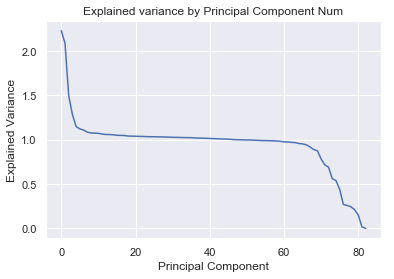

In [103]:
# Plot the explained variance for all principal components
# starting with the 2nd value
pyplot.plot(pca.explained_variance_[1:])
pyplot.title('Explained variance by Principal Component Num')
pyplot.xlabel('Principal Component')
pyplot.ylabel('Explained Variance')

In [105]:
# Perform linear regression with the first N columns.
num_columns = 20
target_label = 'log_price'
# Compose the formula
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(num_columns)]
formula_end = ' + '.join(formula_terms)
formula_final_pcr = formula_start + formula_end

# Choose components with p-value below 0.05
# formula_final = target_label + ' ~ pc11 + pc23 + pc25 + pc31 + pc32 + pc38'

# Train a regression model on the train data 
pcr_model = sm.ols(formula = formula_final_pcr, data = pca_df).fit()

In [106]:
# View linear regression statistics
pcr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.520
Date:                Thu, 14 Mar 2019   Prob (F-statistic):             0.0640
Time:                        13:44:51   Log-Likelihood:                -19715.
No. Observations:               13814   AIC:                         3.947e+04
Df Residuals:                   13793   BIC:                         3.963e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0220      0.009     -2.563      0.010      -0.039      -0.005
pc1           -0.0019      0.004     -0.504      0.614      -0.009       0.005
pc2            0.0059      0.006      1.031      0.302      -0.005       0.017
pc3           -0.0051      0.006     -0.853      0.393      -0.017       0.007
pc4           -0.0054      0.007     -0.771      0.441      -0.019       0.008
pc5            0.0002      0.008      0.023      0.981      -0.015       0.015
pc6           -0.0053      0.008     -0.661      0.508      -0.021       0.010
pc7            0.0080      0.008      1.000      0.317      -0.008       0.024
pc8           -0.0148      0.008     -1.826      0.068      -0.031       0.001
pc9           -0.0067      0.008     -0.820      0.412      -0.023       0.009
pc10          -0.0015      0.008     -0.185      0.853      -0.018       0.015
pc11           0.0280      0.008      3.451      0.001       0.012       0.044
pc12           0.0061      0.008      0.742      0.458      -0.010       0.022
pc13          -0.0032      0.008     -0.384      0.701      -0.019       0.013
pc14           0.0109      0.008      1.319      0.187      -0.005       0.027
pc15          -0.0132      0.008     -1.581      0.114      -0.030       0.003
pc16          -0.0032      0.008     -0.384      0.701      -0.019       0.013
pc17          -0.0155      0.008     -1.846      0.065      -0.032       0.001
pc18           0.0090      0.008      1.071      0.284      -0.007       0.025
pc19          -0.0073      0.008     -0.884      0.376      -0.024       0.009
pc20          -0.0015      0.008     -0.186      0.852      -0.018       0.015
==============================================================================
Omnibus:                      514.396   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              665.130
Skew:                           0.407   Prob(JB):                    3.71e-145
Kurtosis:                       3.702   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Residual Histogram')

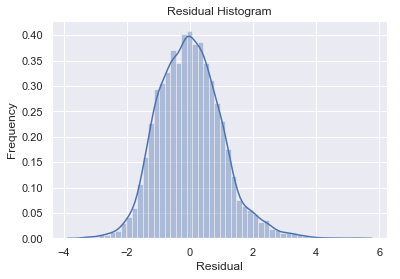

In [107]:
# Plot a histogram of the residuals
sns.distplot(pcr_model.resid, hist = True)
pyplot.xlabel('Residual')
pyplot.ylabel('Frequency')
pyplot.title('Residual Histogram')

In [108]:
# Apply the same PCA to the test set
pca_result_test = pca.transform(XX_test_pcr)[:, :num_columns]

# Put test results into a dataframe
# column_names = ['pc' + str(ix+1) for ix in range(XX_test_pcr.shape[1])]
pca_df_test = pd.DataFrame(data = pca_result_test, columns=column_names[:num_columns])
print('Shape of PCA-transformed test feature set:\n', pca_df_test.shape)

Shape of PCA-transformed test feature set:
 (4323, 20)


In [109]:
# Make predictions using the testing set
y_pred_pcr = pcr_model.predict(pca_df_test)
print('Shape of predictions:\n', y_pred_pcr.shape)

Shape of predictions:
 (4323,)


In [110]:
# Evaluate the model
print("Root mean squared error: %.5f"
      % np.sqrt(mean_squared_error(YY_test_pcr, y_pred_pcr))
     )
# Explained variance score: 1 is perfect prediction
print('Variance score (r-squared): %.5f' % r2_score(YY_test_pcr, y_pred_pcr)
     )

Root mean squared error: 0.98330
Variance score (r-squared): -0.00235


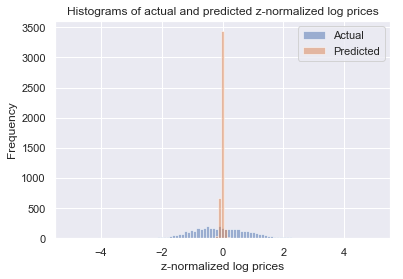

In [111]:
plot_actual_vs_pred(YY_test_pcr, y_pred_pcr,'z-normalized log prices')

It seems that the Principal Component Regression doesn't work. One likely explanation is that there is an error in my process. Another explanation is that the features are already linearly independent and any attempt to make them even more linearly independent via the principal component analysis produces a meaningless result. I get practically the same result regardless of the number of the principal compondents that I select.

## Lasso Regression <a id='lasso'></a>

The purpose of this Lasso regression model is to attempt to reduce the number of parameters in the model without sacrificing its predictive ability compared to the [OLS regression](#ols_regression) (number of parameters = 85, R2 = 0.88, RMSE = 0.35).

In [114]:
# Compute and evaluate a Lasso Regression model with a sequence of lambdas (for all data)

# The higher the value of the alpha constant, the more of the model coefficients are 
# set to zero and, thus, more model parameters (i.e. terms) are eliminated.

# Generate a sequence of 50 lambdas that the alpha constant will be set to
log_lambda_seq = np.linspace(-6, 2, 50)
lambda_seq = np.exp(log_lambda_seq)

# Store coefficients and r-squared for each model computed
coeffs_array = []
rsq_array = []
# Final formual with all the terms (from OLS regression section)
formula = formula_final

# Statsmodels provide the elastic net method. Lasso is a specific case of elastic net
# L1_wt=0 for Ridge regression, L1_wt=1 for Lasso regression
for lamb in lambda_seq:
    lasso_model = sm.ols(formula, data=house_expanded_scaled).fit_regularized(method='elastic_net', 
                                                                              alpha=lamb, 
                                                                              L1_wt=1)
    coeffs_array.append(list(lasso_model.params))
    predictions = lasso_model.fittedvalues
    residuals = [x - y for x, y in zip(np.squeeze(predictions), y_house)]

    SSR = np.sum(np.square(residuals))
    SST = np.sum(np.square(y_house - np.mean(y_house)))

    rsq = 1 - (SSR / SST)
    rsq_array.append(rsq)

Text(0.5, 0, 'Log-Lambda')

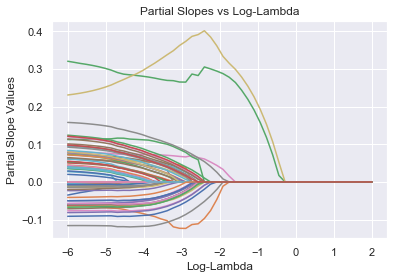

In [115]:
# Pull out partial slopes (drop intercept version)
beta_coeffs = [x[1:] for x in coeffs_array]
pyplot.plot(log_lambda_seq, beta_coeffs)
pyplot.title('Partial Slopes vs Log-Lambda')
pyplot.ylabel('Partial Slope Values')
pyplot.xlabel('Log-Lambda')

As lambda increases the values of all model coefficients converge to zero, which should lead low variance but large bias (i.e. underfitting). For small values of lambda, the situation should be the opposite.

Text(0, 0.5, 'Partial Slopes')

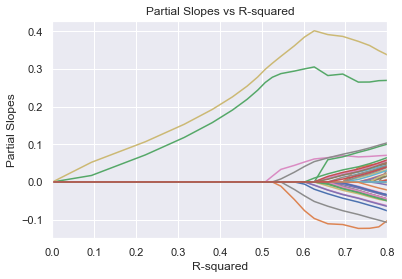

In [116]:
# Plot partial slopes vs R squared (% deviance explained)
pyplot.plot(rsq_array, beta_coeffs)
pyplot.xlim([0.0, 0.8])
pyplot.title('Partial Slopes vs R-squared')
pyplot.xlabel('R-squared')
pyplot.ylabel('Partial Slopes')

For higher values of r-squared about one half or one third of the coefficients have values below zero.

### Using a train-test split

I will compute a list of RMSEs and r-squared scores for 50 alpha values from the sequence defined above but by using the training set only. Then I will choose the alpha value which produces the highest r-squared score and the lowest RMSE.

In [117]:
def get_removed_params(model_params_object):
    """Return model parameters whose coefficients were set to zero."""
    removed_parameters = []
    for parameter in model_params_object.keys():
        if model_params_object[parameter] == 0:
            removed_parameters.append(parameter)
    return removed_parameters

In [118]:
# Compose a list of (r2, rmse, number of parameters removed) for 50 lambdas
rmse_list = []
for lam in lambda_seq:
    lasso_model_temp = sm.ols(formula_final, data=X_train).fit_regularized(method='elastic_net',
                                                                           alpha=lam,
                                                                           L1_wt=1)
    y_pred_lasso_temp = lasso_model_temp.predict(XX_test)  # Predict log prices on the test set
    
    rmse_temp = np.sqrt(mean_squared_error(YY_test, y_pred_lasso_temp))  # Compute RMSE
    r2_score_temp = r2_score(YY_test, y_pred_lasso_temp)  # Compute r2
    num_params_removed_temp = len(get_removed_params(lasso_model_temp.params))

    rmse_list.append((r2_score_temp, rmse_temp, num_params_removed_temp))

In [119]:
# Put the scores into a dataframe
rmse_r2_df = pd.DataFrame(rmse_list, columns = ['r2', 'RMSE', 'num_params_removed'])
rmse_r2_df['alpha'] = lambda_seq
rmse_r2_df['log_alpha'] = log_lambda_seq

In [120]:
rmse_r2_df.head()

,r2,RMSE,num_params_removed,alpha,log_alpha
0,0.867529,0.357467,13,0.002479,-6.000000
1,0.866407,0.358977,14,0.002918,-5.836735
2,0.866168,0.359298,14,0.003436,-5.673469
3,0.865828,0.359754,14,0.004045,-5.510204
4,0.865345,0.360401,14,0.004763,-5.346939


Text(0, 0.5, 'Number of parameters removed')

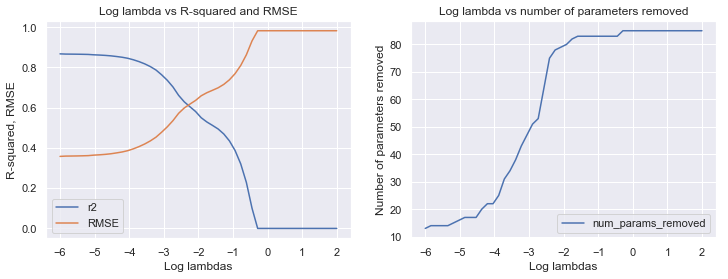

In [121]:
# Plot log alphas vs R-squared and RMSE
fig, (ax1, ax2) = pyplot.subplots(1, 2)
rmse_r2_df.plot('log_alpha', ['r2', 'RMSE'], ax=ax1, figsize=(12, 4))
ax1.set_title('Log lambda vs R-squared and RMSE')
ax1.set_xlabel('Log lambdas')
ax1.set_ylabel('R-squared, RMSE')

rmse_r2_df.plot('log_alpha', 'num_params_removed', ax=ax2)
ax2.set_title('Log lambda vs number of parameters removed')
ax2.set_xlabel('Log lambdas')
ax2.set_ylabel('Number of parameters removed')

As can be seen in the table and plot above, the highest r2 value that can be achieved is about 0.87, with RMSE of about 0.36. The corresponding alpha is 0.002479, and I will use it in the Lasso regression model below. This reduces the number of model parameters by 13.

In [122]:
# Train a Lasso regression model on the X-train data (which includes Y-train data values)
lasso_model = sm.ols(formula_final, data=X_train).fit_regularized(method='elastic_net',
                                                                  alpha=0.002479,
                                                                  L1_wt=1)

In [123]:
# Make predictions using the testing set
y_pred_lasso = lasso_model.predict(XX_test)

# The mean squared error
print("Root mean squared error: %.5f"
      % np.sqrt(mean_squared_error(YY_test, y_pred_lasso))
     )
# Explained variance score: 1 is perfect prediction
print('Variance score (r-squared): %.5f' % r2_score(YY_test, y_pred_lasso)
     )

lasso_model.summary()

Root mean squared error: 0.35747
Variance score (r-squared): 0.86753


In [124]:
# Calculate how many features has been assigned zero coefficients by the Lasso model above
removed_parameters = get_removed_params(lasso_model.params)

init_num_param = len(lasso_model.params)
num_param_removed = len(removed_parameters)
print('Initial number of parameters:', init_num_param)
print('Number of parameters removed:', num_param_removed)
print('Number of parameters remaining:', init_num_param - num_param_removed)

print('\nThe Lasso model assigned zero coefficients to the following terms of the model:\n')
print(removed_parameters)

Initial number of parameters: 85
Number of parameters removed: 13
Number of parameters remaining: 72

The Lasso model assigned zero coefficients to the following terms of the model:

['Intercept', 'bedrooms', 'floors', 'sqft_above', 'sqft_lot15', 'zipcode_98011', 'zipcode_98024', 'zipcode_98028', 'zipcode_98065', 'zipcode_98077', 'zipcode_98118', 'zipcode_98133', 'zipcode_98155']


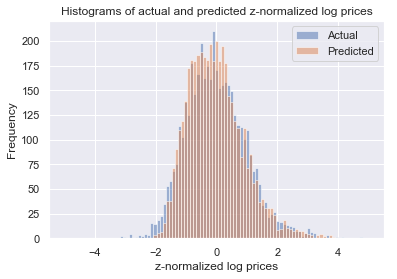

In [125]:
plot_actual_vs_pred(YY_test, y_pred_lasso,'z-normalized log prices')

The plot above shows a good overlap between the actual and predicted prices.

### Summary on Lasso regression

Using the Lasso regresson with the alpha constant of 0.002479 allowed getting rid of 13 parameters in the model compared to the OLS regression model which has 85 parameters. The Lesso regression's r-squared is 0.86753 and the RMSE is 0.35747 compared to 0.87516 and 0.34702, respectively, in the OLS regression model. In other words, getting rid of these 13 parameters does not lead to a loss in performance. 

[Back to top](#top)

### Ridge Model Summary

A ridge regression model produces results practically identical to the lasso model above for the same alpha level (=0.002479) (which gives the optimal combination of the r-squared score and RMSE), but without the benefit of dropping some terms from the model. I omit the code related to the ridge model because it is almost the same as for the lasso model above except for setting L1_wt = 0.

## Conclusions <a id='conclusions'></a>

1. Comparison of the performance of the models

I have built 5 models for this house prices dataset. 1 - Multiple Ordinary Least Squares (OLS) linear regression; 2 - Naive Bayes Classifer; 3 - Principal Component Regression (PCR); 4 - Lasso Regression; 5 - Ridge Regression (I omitted code for this one because it is almost the same as for the Lasso Regression).

The <b>OLS regression</b> model produces the best results, with r-squared of 0.87516 and RMSE of 0.34702, and the number of terms in its formula being 85. The <b>Lesso regression</b> simplifies the above model by reducing the number of formula terms by 13, while retaining r-squared and RMSE at about the same level (0.86753 and 0.35747, respectively). 

_I note that the r-squared score ranges from 0 to 1, indicating the extent to which the target variable is predictable from the data, where 1 means that the target variable can be predicted without error._

_Also, RMSE is a measure of distance between actual values and predictions. RMSE is relative to the range of the underlying data. With the range of the underlying data from about -3.1 to 4.7 (these figures are scaled logs of prices), RMSE of about 0.3-0.4 does not look bad._

I found the other models, namely, Naive Bayes, PCR, and Ridge, to be not useful for this dataset.

2. Data features

When building the models, I removed from the feature set the house latitude and longitude data, because taking into consideration these features would probably have required a very complicated process. But, the data also includes zipcodes which might probably account for the house location.

No single feature in the data set is a good predictor of the house prices because there are numerious outliers in each feature. The combination of all the features in the regression model, however, is relatively good at predicting the prices.

[Back to top](#top)